<a href="https://colab.research.google.com/github/harshavardhangadila/Computer-Vision-Examples/blob/main/Supervised%20Contrastive%20Learning/Supervised_Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1: Imports (from built-in versions, no pip installs)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import pandas as pd

sns.set(style="whitegrid")
%matplotlib inline

# 2: Seed and hyperparameters
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

BATCH_SIZE_PRETRAIN = 1024
BATCH_SIZE_FINETUNE = 64
EPOCHS_PRETRAIN = 20
EPOCHS_FINETUNE = 15
PROJECTION_DIM = 128
LEARNING_RATE = 1e-3




29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
# 3: Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 784)).astype("float32")
x_test = x_test.reshape((-1, 784)).astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE_PRETRAIN)
train_ds_finetune = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE_FINETUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE_FINETUNE)

In [3]:
# 4: Model definitions

class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(512, activation='relu')
        self.d2 = tf.keras.layers.Dense(256, activation='relu')

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        return tf.math.l2_normalize(x, axis=1)

class Projector(tf.keras.Model):
    def __init__(self, proj_dim=128):
        super().__init__()
        self.p1 = tf.keras.layers.Dense(256, activation='relu')
        self.p2 = tf.keras.layers.Dense(proj_dim)

    def call(self, x):
        x = self.p1(x)
        x = self.p2(x)
        return tf.math.l2_normalize(x, axis=1)

class Classifier(tf.keras.Model):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc = tf.keras.layers.Dense(num_classes)

    def call(self, x):
        return self.fc(x)


In [4]:
# 5: Supervised contrastive loss (NT-Xent)

def supervised_nt_xent_loss(features, labels, temperature=0.1):
    features = tf.math.l2_normalize(features, axis=1)
    sim_matrix = tf.matmul(features, features, transpose_b=True)
    logits = sim_matrix / temperature

    labels = tf.expand_dims(labels, 1)
    mask = tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32)
    logits_mask = tf.cast(~tf.eye(tf.shape(labels)[0], dtype=tf.bool), tf.float32)
    mask *= logits_mask

    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / tf.reduce_sum(mask, axis=1)
    return -tf.reduce_mean(mean_log_prob_pos)


In [5]:
# 6: Pretraining (Encoder + Projector)

encoder = Encoder()
projector = Projector(PROJECTION_DIM)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

@tf.function
def contrastive_train_step(x, y):
    with tf.GradientTape() as tape:
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = supervised_nt_xent_loss(z, y)
    vars = encoder.trainable_variables + projector.trainable_variables
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))
    return loss

for epoch in range(EPOCHS_PRETRAIN):
    total_loss = 0.0
    for x_batch, y_batch in train_ds:
        loss = contrastive_train_step(x_batch, y_batch)
        total_loss += loss.numpy()
    print(f"Epoch {epoch+1}: Contrastive Loss = {total_loss / len(train_ds):.4f}")


Epoch 1: Contrastive Loss = 5.4629
Epoch 2: Contrastive Loss = 5.2459
Epoch 3: Contrastive Loss = 5.1812
Epoch 4: Contrastive Loss = 5.1376
Epoch 5: Contrastive Loss = 5.1062
Epoch 6: Contrastive Loss = 5.0714
Epoch 7: Contrastive Loss = 5.0581
Epoch 8: Contrastive Loss = 5.0396
Epoch 9: Contrastive Loss = 5.0231
Epoch 10: Contrastive Loss = 5.0065
Epoch 11: Contrastive Loss = 4.9908
Epoch 12: Contrastive Loss = 4.9874
Epoch 13: Contrastive Loss = 4.9703
Epoch 14: Contrastive Loss = 4.9606
Epoch 15: Contrastive Loss = 4.9572
Epoch 16: Contrastive Loss = 4.9421
Epoch 17: Contrastive Loss = 4.9288
Epoch 18: Contrastive Loss = 4.9175
Epoch 19: Contrastive Loss = 4.9150
Epoch 20: Contrastive Loss = 4.9062


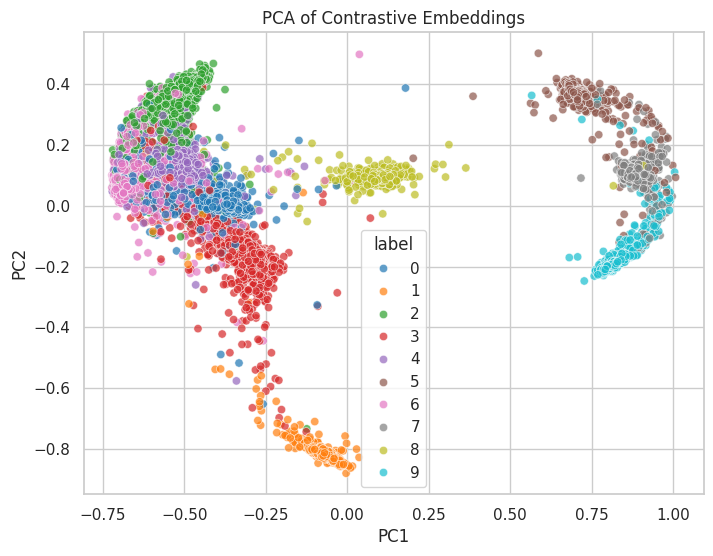

In [6]:
# 7: PCA Visualization

embeds = projector(encoder(x_test, training=False)).numpy()
pca = PCA(n_components=2).fit_transform(embeds)

df = pd.DataFrame(pca, columns=["PC1", "PC2"])
df["label"] = y_test

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PC1", y="PC2", hue="label", palette="tab10", alpha=0.7)
plt.title("PCA of Contrastive Embeddings")
plt.show()


In [8]:
# 8: Train classifier on frozen encoder

# Freeze encoder after contrastive training
encoder.trainable = False

# Initialize classifier model
classifier = Classifier()

# Optimizer and loss function for classifier
optimizer2 = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Accuracy metrics
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc = tf.keras.metrics.SparseCategoricalAccuracy()

# Training step for classifier
@tf.function
def train_step_cls(x, y):
    with tf.GradientTape() as tape:
        features = encoder(x, training=False)  # Use frozen encoder
        logits = classifier(features, training=True)
        loss = loss_fn(y, logits)
    grads = tape.gradient(loss, classifier.trainable_variables)
    optimizer2.apply_gradients(zip(grads, classifier.trainable_variables))
    train_acc.update_state(y, logits)
    return loss

# Test step for classifier
@tf.function
def test_step_cls(x, y):
    features = encoder(x, training=False)
    logits = classifier(features, training=False)
    test_acc.update_state(y, logits)

# Training loop
for epoch in range(EPOCHS_FINETUNE):
    train_acc.reset_state()
    test_acc.reset_state()

    for x_batch, y_batch in train_ds_finetune:
        train_step_cls(x_batch, y_batch)

    for x_batch, y_batch in test_ds:
        test_step_cls(x_batch, y_batch)

    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc.result()*100:.2f}%, Test Accuracy = {test_acc.result()*100:.2f}%")



Epoch 1: Train Accuracy = 89.44%, Test Accuracy = 88.47%
Epoch 2: Train Accuracy = 93.14%, Test Accuracy = 88.94%
Epoch 3: Train Accuracy = 93.61%, Test Accuracy = 89.36%
Epoch 4: Train Accuracy = 93.92%, Test Accuracy = 89.46%
Epoch 5: Train Accuracy = 94.16%, Test Accuracy = 89.52%
Epoch 6: Train Accuracy = 94.38%, Test Accuracy = 89.53%
Epoch 7: Train Accuracy = 94.56%, Test Accuracy = 89.67%
Epoch 8: Train Accuracy = 94.75%, Test Accuracy = 89.77%
Epoch 9: Train Accuracy = 94.83%, Test Accuracy = 89.79%
Epoch 10: Train Accuracy = 94.97%, Test Accuracy = 89.81%
Epoch 11: Train Accuracy = 95.07%, Test Accuracy = 89.79%
Epoch 12: Train Accuracy = 95.11%, Test Accuracy = 89.82%
Epoch 13: Train Accuracy = 95.19%, Test Accuracy = 89.81%
Epoch 14: Train Accuracy = 95.23%, Test Accuracy = 89.85%
Epoch 15: Train Accuracy = 95.31%, Test Accuracy = 89.89%


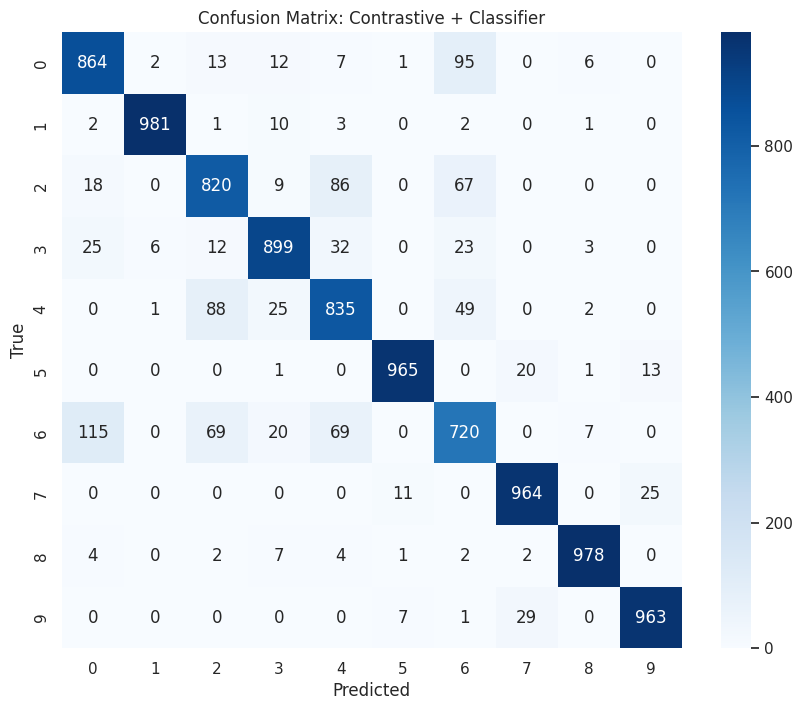

In [9]:
# 9: Confusion Matrix

y_pred, y_true = [], []
for x_batch, y_batch in test_ds:
    logits = classifier(encoder(x_batch, training=False))
    preds = tf.argmax(logits, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(y_batch.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Contrastive + Classifier")
plt.show()
